In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import math
from tqdm import tqdm
from matplotlib import pyplot as pl

In [5]:
data = np.array([[1.3461, 1.102, 0.911],
[1.6154, 1.208, 0.944],
[1.8846, 1.336, 0.979]]) #rome form factor data, plus = 1, zero = 2

In [3]:
chi0plus = 0.00433
chi1minus = 0.00419

In [4]:
zerosum = (1.86484-0.497611)**2 #D0 and K0

In [5]:
plusminussum = (1.86966-0.493677)**2 #D+- and K+-

In [6]:
0.5*(zerosum+plusminussum)

1.8813221773650004

In [7]:
MD = 0.5*(1.86484+1.86966)
MK = 0.5*(0.497611+0.493677)
(MD-MK)**2 #?????????????? where does their 1.8846 come from?

1.8813030192360003

In [8]:
tminus = 1.8846 #(MD-MK)**2
tplus = (MD+MK)**2
tplus = 5.588946789081293

In [9]:
def z(t):
    return (np.sqrt(tplus-t)-np.sqrt(tplus-tminus))/(np.sqrt(tplus-t)+np.sqrt(tplus-tminus))

In [10]:
def rho(t):
    return np.sqrt((tplus-t)/(tplus-tminus))

In [11]:
ni = 2

In [12]:
def phizero(t):  #outer fn and Blanschke factors
    polevals = [2.3178**2]
    calcz = z(t)
    calcrho = rho(t)
    phizeroval = np.sqrt(2*ni/3)*np.sqrt((3*tplus*tminus)/(4*np.pi))*1/(tplus-tminus)*(1+calcz)*np.power(1-calcz,-5/2)*np.power(rho(0)+(1+calcz)/(1-calcz),-2)*np.power(rho(0)+(1+calcz)/(1-calcz),-2)
    for i in range(len(polevals)):
        phizeroval *= (z(t)-z(polevals[i]))/(1-np.conjugate(z(polevals[i]))*z(t))
    return phizeroval 

In [13]:
def phiplus(t):  #outer fn and Blanschke factors
    polevals = [2.1122**2]
    calcz = z(t)
    calcrho = rho(t)
    phiplusval = np.sqrt(2*ni/3)*np.sqrt(1/(np.pi*(tplus-tminus)))*np.power(1+calcz,2)*np.power(1-calcz,-9/2)*np.power(rho(0)+(1+calcz)/(1-calcz),-2)*np.power(rho(0)+(1+calcz)/(1-calcz),-3)
    for i in range(len(polevals)):
        phiplusval *= (z(t)-z(polevals[i]))/(1-np.conjugate(z(polevals[i]))*z(t))
    return phiplusval

In [14]:
def exclude(G,a,b):
    return np.delete(np.delete(G,b,0),a,1)

In [15]:
#2105.02497 pg 48-50

In [16]:
def alpha(data,charge):
    if charge == 1:
        index = 1
    elif charge == 0:
        index = 2
    alphamat = np.empty([data.shape[0],data.shape[0]])

    for i in range(data.shape[0]):
        for j in range(data.shape[0]):
            alphamat[i,j] = 1/(1-z(data[i,0])*z(data[j,0]))
    return np.linalg.det(alphamat)

In [17]:
def G(data,t):
    row = [t]
    row.extend(data[:,0])
    mat = np.empty([data.shape[0]+1,data.shape[0]+1])

    for i in range(len(row)):
        for j in range(len(row)):
            mat[i,j] = 1/(1-z(row[i])*z(row[j]))
    return mat

In [18]:
def beta(data, t, charge):
    if charge == 1:
        index = 1
        phi = phiplus
    elif charge == 0:
        index = 2
        phi = phizero
    ssum = 0
    for j in range(1,data.shape[0]+1):
        ssum += ((-1)**j)*phi(data[j-1,0])*data[j-1,index]*np.linalg.det(exclude(G(data,t),0,j))
    return ssum

In [19]:
def gamma(data, t,charge,chi):
    if charge == 1:
        index = 1
        phi = phiplus
    elif charge == 0:
        index = 2
        phi = phizero
    ssum = chi*np.linalg.det(G(data,t))
    for i in range(1,data.shape[0]+1):
        for j in range(1,data.shape[0]+1):
            ssum -= np.power(-1,j+i)*phi(data[i-1,0])*data[i-1,index]*phi(data[j-1,0])*data[j-1,index]*np.linalg.det(exclude(G(data,t),i,j))
    return ssum

In [20]:
def M11(data,t,charge,chi):
    if charge == 1:
        index = 1
        phi = phiplus
    elif charge == 0:
        index = 2
        phi = phizero
    mat = np.empty([data.shape[0]+1,data.shape[0]+1])
    mat[0,0] = chi
    for i in range(1,data.shape[0]+1):
        mat[i,0] = phi(data[i-1,0])*data[i-1,index]
        mat[0,i] = phi(data[i-1,0])*data[i-1,index]
        for j in range(1,data.shape[0]+1):
            mat[i,j] = G(data,t)[i,j]
    return mat

In [21]:
def formfactor(data, t,charge,chi):
    if charge == 1:
        phi = phiplus
    elif charge == 0:
        phi = phizero
    calcalpha = alpha(data,charge)
    calcbeta = beta(data,t,charge)
    #calcgamma = gamma(data,t,charge,chi)
    #eigenvaluesM11 = np.linalg.eig(M11(data,t,1,chi))[0]
    #eigenvaluesG = np.linalg.eig(G(data,t))[0]
    discrimM11G = np.exp(np.linalg.slogdet(M11(data,t,charge,chi))[1])*np.exp(np.linalg.slogdet(G(data,t))[1])
    if discrimM11G < 0:
        print("discriminant is negative: ",discrimM11G)
        print("M11 eigenvalues are: ",eigenvaluesM11)
#     if np.linalg.det(M11(data,t,charge,chi)) < 0:
#         print("M11 np.linalg.det: ",np.linalg.det(M11(data,t,charge,chi)))
#         print("M11 np.linalg.slogdet: ",np.exp(np.linalg.slogdet(M11(data,t,charge,chi))))
#     if np.linalg.det(G(data,t)) < 0:
#         print("G np.linalg.det: ",np.linalg.det(G(data,t)))
#         print("G np.linalg.slogdet: ",np.exp(np.linalg.slogdet(G(data,t))))
        #print("G eigenvalues are: ",eigenvaluesG)
    lowerbound = (-calcbeta-np.sqrt(discrimM11G))/(calcalpha*phi(t))
    upperbound = (-calcbeta+np.sqrt(discrimM11G))/(calcalpha*phi(t))
    return [lowerbound,upperbound]

<ipython-input-96-216355fa68a5>:2: RuntimeWarning: invalid value encountered in sqrt
  return (np.sqrt(tplus-t)-np.sqrt(tplus-tminus))/(np.sqrt(tplus-t)+np.sqrt(tplus-tminus))
C:\Users\09cra\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2159: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Users\09cra\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2099: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
<ipython-input-96-216355fa68a5>:2: RuntimeWarning: invalid value encountered in sqrt
  return (np.sqrt(tplus-t)-np.sqrt(tplus-tminus))/(np.sqrt(tplus-t)+np.sqrt(tplus-tminus))
C:\Users\09cra\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2159: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Users\09cra\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2099: RuntimeWarning: invalid value encountered in slogd

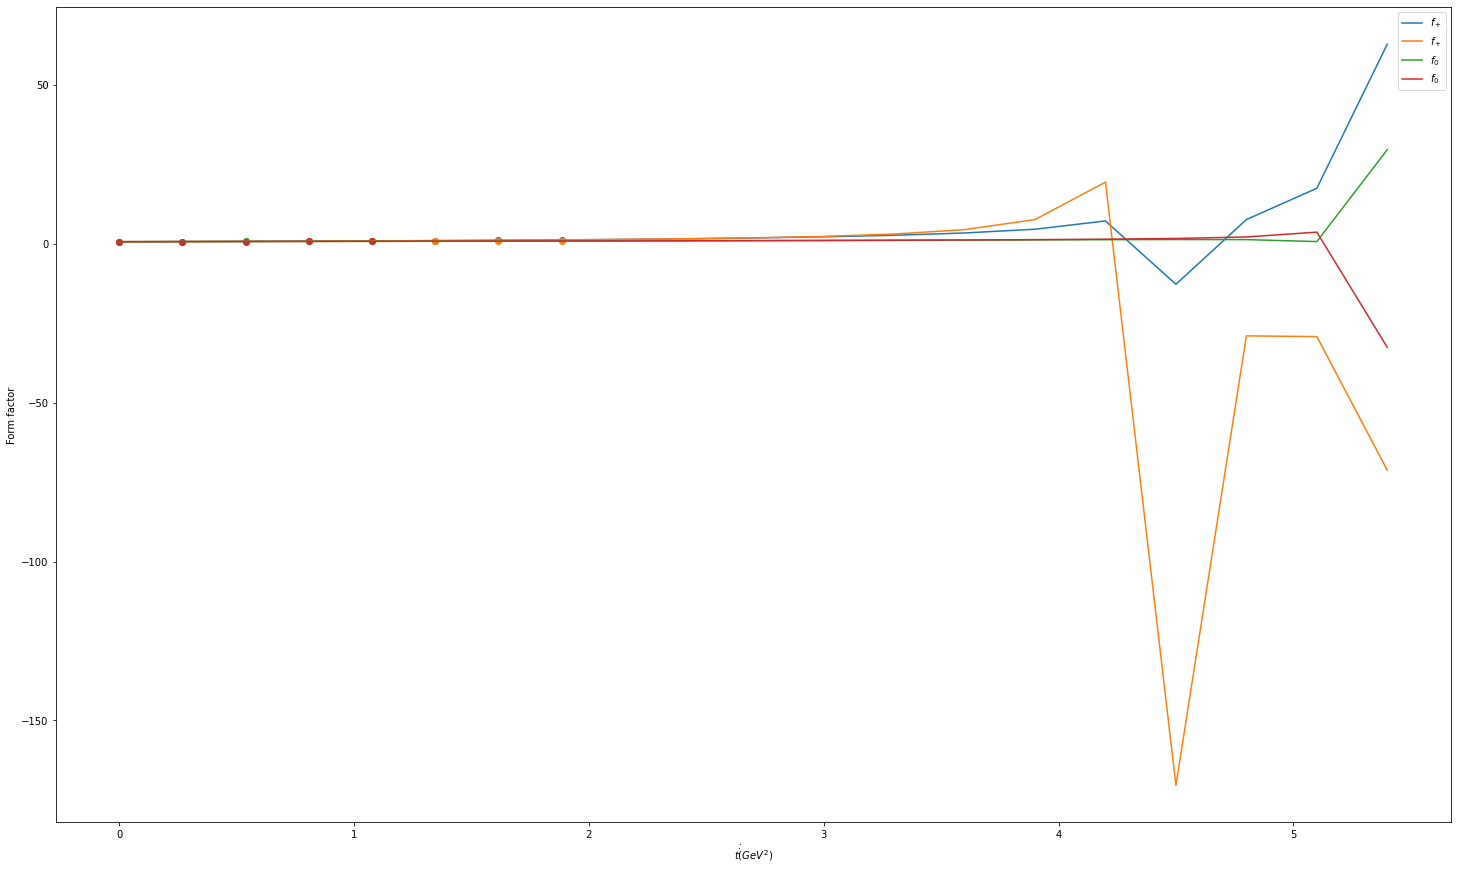

In [235]:
x = np.linspace(0,30,101)
plt.plot(x,[formfactor(data,i,1,chi1minus) for i in x],label = r"$f_+$")
plt.plot(x,[formfactor(data,i,0,chi0plus) for i in x],label = r"$f_0$")
plt.scatter(data[:,0],data[:,1])
plt.scatter(data[:,0],data[:,2])

romevals = np.array([[0.0, 0.765, 0.765, 0.772, 0.772],
[0.2692, 0.815, 0.792, 0.822, 0.800],
[0.5385, 0.872, 0.820, 0.878, 0.826],
[0.8077, 0.937, 0.849, 0.942, 0.853],
[1.0769, 1.013, 0.879, 1.015, 0.882]])
plt.scatter(romevals[:,0],romevals[:,3])
plt.scatter(romevals[:,0],romevals[:,4])
plt.xlabel(r"$t \.\.(GeV^2)$")
plt.ylabel("Form factor")
plt.legend()
plt.show()

In [110]:
formfactor(data,0,1,chi1minus)

[0.7490661753405103, 0.7764018700296765]

In [111]:
formfactor(data,0,0,chi0plus)

[0.7662603806702283, 0.7697023709344194]

In [112]:
[alpha(data,0),alpha(data,1)]

[9.520783852637174e-11, 9.520783852637174e-11]

In [113]:
[phizero(1.3461),phiplus(1.3461)]

[0.012599923611854783, 0.002105802438885899]

In [114]:
[phizero(1.6154),phiplus(1.6154)]

[0.012432362683113547, 0.0019451931170881291]

In [115]:
[phizero(1.8846),phiplus(1.8846)]

[0.012238525484629238, 0.0017799238553236649]

In [116]:
M11(data,0,0,chi0plus)

array([[0.00433   , 0.01147853, 0.01173615, 0.01198152],
       [0.01147853, 1.00115181, 1.00059516, 1.        ],
       [0.01173615, 1.00059516, 1.00030761, 1.        ],
       [0.01198152, 1.        , 1.        , 1.        ]])

In [117]:
np.linalg.det(M11(data,0,0,chi0plus))

1.3429967969086048e-13

In [118]:
##### Uncertainty #######

In [22]:
# Normal distribution sampling
SDarray = np.array([
[0.038, 0.019],
[0.044, 0.019],
[0.054, 0.019]])

In [6]:
covmatrix = np.array([[0.00095048337, 0.00086115559, 0.00076822929, 0.00067139737, 0.00057032189, 0.00046461266, 0.00035382373, 0.00023743786, 0.00093372326, 0.00091131333, 0.00088169768, 0.00084279034, 0.00079172189, 0.00072447152, 0.00063523124],  
[0.00086115559, 0.00078515556, 0.00070607957, 0.00062368504, 0.00053767967, 0.00044773144, 0.00035346098, 0.00025442805, 0.00085206316, 0.00083894582, 0.00082066442, 0.00079568390, 0.00076188560, 0.00071629634, 0.00065461116],  
[0.00076822929, 0.00070607957, 0.00064142818, 0.00057404882, 0.00050372187, 0.00043017086, 0.00035308565, 0.00027210610, 0.00076710907, 0.00076365966, 0.00075717032, 0.00074667912, 0.00073084851, 0.00070779522, 0.00067477803],  
[0.00067139737, 0.00062368504, 0.00057404882, 0.00052233064, 0.00046833577, 0.00041187082, 0.00035269283, 0.00029052511, 0.00067858404, 0.00068520846, 0.00069100626, 0.00069561272, 0.00069850419, 0.00069893308, 0.00069578757],  
[0.00057032189, 0.00053767967, 0.00050372187, 0.00046833577, 0.00043140396, 0.00039276887, 0.00035228288, 0.00030975141, 0.00058617957, 0.00060331939, 0.00062194289, 0.00064230877, 0.00066474294, 0.00068968328, 0.00071771878],  
[0.00046461266, 0.00044773144, 0.00043017086, 0.00041187082, 0.00039276887, 0.00037279630, 0.00035185424, 0.00032985927, 0.00048953884, 0.00051767609, 0.00054971326, 0.00058656101, 0.00062943376, 0.00068000920, 0.00074065513],  
[0.00035382373, 0.00035346098, 0.00035308565, 0.00035269283, 0.00035228288, 0.00035185424, 0.00035141065, 0.00035093414, 0.00038825440, 0.00042791779, 0.00047401349, 0.00052813546, 0.00059242935, 0.00066987229, 0.00076469633],  
[0.00023743786, 0.00025442805, 0.00027210610, 0.00029052511, 0.00030975141, 0.00032985927, 0.00035093414, 0.00037307838, 0.00028185308, 0.00033362480, 0.00039448913, 0.00046675785, 0.00055355489, 0.00065922240, 0.00078995092],  
[0.00093372326, 0.00085206316, 0.00076710907, 0.00067858404, 0.00058617957, 0.00048953884, 0.00038825440, 0.00028185308, 0.00093183118, 0.00092700129, 0.00091836176, 0.00090470689, 0.00088436880, 0.00085499959, 0.00081318331],  
[0.00091131333, 0.00083894582, 0.00076365966, 0.00068520846, 0.00060331939, 0.00051767609, 0.00042791779, 0.00033362480, 0.00092700129, 0.00094300108, 0.00095919909, 0.00097546032, 0.00099153820, 0.00100707070, 0.00102148152],  
[0.00088169768, 0.00082066442, 0.00075717032, 0.00069100626, 0.00062194289, 0.00054971326, 0.00047401349, 0.00039448913, 0.00091836176, 0.00095919909, 0.00100505872, 0.00105703236, 0.00111659949, 0.00118576848, 0.00126735992],  
[0.00084279034, 0.00079568390, 0.00074667912, 0.00069561272, 0.00064230877, 0.00058656101, 0.00052813546, 0.00046675785, 0.00090470689, 0.00097546032, 0.00105703236, 0.00115205144, 0.00126402614, 0.00139785199, 0.00156044486],  
[0.00079172189, 0.00076188560, 0.00073084851, 0.00069850419, 0.00066474294, 0.00062943376, 0.00059242935, 0.00055355489, 0.00088436880, 0.00099153820, 0.00111659949, 0.00126402614, 0.00143985862, 0.00165246003, 0.00191376844],  
[0.00072447152, 0.00071629634, 0.00070779522, 0.00069893308, 0.00068968328, 0.00068000920, 0.00066987229, 0.00065922240, 0.00085499959, 0.00100707070, 0.00118576848, 0.00139785199, 0.00165246003, 0.00196229709, 0.00234545168],  
[0.00063523124, 0.00065461116, 0.00067477803, 0.00069578757, 0.00071771878, 0.00074065513, 0.00076469633, 0.00078995092, 0.00081318331, 0.00102148152, 0.00126735992, 0.00156044486, 0.00191376844, 0.00234545168, 0.00288135740]])

In [7]:
def resample(data):
    resample = data.copy()
    for i in range(1,data.shape[1]):
        for j in range(data.shape[0]):
            resample[j,i] = np.random.normal(data[j,i],SDarray[j,i-1])
    return resample

In [8]:
excludelist = [0,1,2,3,4,8,9,10,11]
trimmedcov = np.delete(covmatrix,excludelist,axis=0)
trimmedcov = np.delete(trimmedcov,excludelist,axis=1)

In [9]:
trimmedcov

array([[0.0003728 , 0.00035185, 0.00032986, 0.00062943, 0.00068001,
        0.00074066],
       [0.00035185, 0.00035141, 0.00035093, 0.00059243, 0.00066987,
        0.0007647 ],
       [0.00032986, 0.00035093, 0.00037308, 0.00055355, 0.00065922,
        0.00078995],
       [0.00062943, 0.00059243, 0.00055355, 0.00143986, 0.00165246,
        0.00191377],
       [0.00068001, 0.00066987, 0.00065922, 0.00165246, 0.0019623 ,
        0.00234545],
       [0.00074066, 0.0007647 , 0.00078995, 0.00191377, 0.00234545,
        0.00288136]])

In [10]:
def covresample(data):
    vectordata = np.hstack([data[:,2],data[:,1]])
    excludelist = [0,1,2,3,4,8,9,10,11]
    trimmedcov = np.delete(covmatrix,excludelist,axis=0)
    trimmedcov = np.delete(trimmedcov,excludelist,axis=1)
    resampledvectordata = np.random.multivariate_normal(vectordata,trimmedcov)
    resampleddata = np.array([data[:,0],resampledvectordata[3:6],resampledvectordata[0:3]])
    return np.transpose(resampleddata)

In [11]:
data

array([[1.3461, 1.102 , 0.911 ],
       [1.6154, 1.208 , 0.944 ],
       [1.8846, 1.336 , 0.979 ]])

In [34]:
#np.random.seed(seed=1)
covresample(data)

array([[1.3461    , 1.09103656, 0.91919107],
       [1.6154    , 1.18914051, 0.9516276 ],
       [1.8846    , 1.30711201, 0.98574901]])

In [1]:
def dispmethod(chg,tchosen,Nboot):
    N0 = 5
    fbaruplist = []
    fbarlolist = []
    accepted_resamples = []
    nancount = 0
    unifailcount = 0
    for y in range(Nboot):
        newdata = covresample(data)
        chiplus = np.random.normal(chi1minus,0.00036)
        chizero = np.random.normal(chi0plus,0.00133)
        
        if chg == 1:
            chi = chiplus
        if chg == 0:
            chi = chizero
        
        plusbounds = formfactor(newdata,0,1,chiplus)
        zerobounds = formfactor(newdata,0,0,chizero)
        upper = min(plusbounds[1],zerobounds[1])
        lower = max(plusbounds[0],zerobounds[0])
        if upper <= lower:
            continue
        if np.linalg.det(M11(newdata,tchosen,1,chiplus)) < 0 or np.linalg.det(M11(newdata,tchosen,0,chizero)) < 0:
            #print("unitarity check failed")
            unifailcount += 1
            continue
        fbarup = 0
        fbarlo = np.Inf
        rangeN0 = np.linspace(lower,upper,N0)
        for k in rangeN0:
            originval = k#np.random.uniform(lower,upper)
            extendednewdata = np.vstack([newdata,[0,originval,originval]])
            
            tchosenbounds = formfactor(extendednewdata,tchosen,chg,chi)
            fbarup = max(tchosenbounds[1],fbarup)
            fbarlo = min(tchosenbounds[0],fbarlo)
            
        
        if np.isnan(fbarup):
            nancount+=1
        if nancount > 10:
            print("NaN values skipped for t=",tchosen)
            break
        fbaruplist.append(fbarup)
        fbarlolist.append(fbarlo)
        accepted_resamples.append(newdata)
    print("for t = ",tchosen," unitarity fail percentage is ",(unifailcount*100)/Nboot,"%")
    print("for t = ",tchosen," other fail percentage is ",((Nboot-len(fbarlolist)-unifailcount)*100)/Nboot,"%")
    return [fbarlolist,fbaruplist,accepted_resamples]

In [162]:
##investigating why calcbeta**2 + calcalpha*calcgamma is negative for some t's

def sqrtcheck(data, t,charge):
    if charge == 1:
        phi = phiplus
    elif charge == 0:
        phi = phizero
    calcalpha = alpha(data,charge)
    calcbeta = beta(data,t,charge)
    calcgamma = gamma(data,t,charge)
    output = calcbeta**2 + calcalpha*calcgamma
    return output

In [127]:
tchosenlist = [0.0, 0.2692, 0.5385, 0.8077, 1.0769, 1.3461, 1.6154, 1.8846] #np.linspace(0,1.8,31)#[0.01,0.2692,0.5384,0.8077,1.0769,1.4,1.65,1.8]#[1.26]#

In [197]:
Nboot = 1000
dispresultsplus = np.empty([len(tchosenlist),4])
histplus = np.zeros([len(tchosenlist),3], dtype=np.object)
accepted_dataset_plus = np.zeros([len(tchosenlist),2], dtype=np.object)
counter = 0
for tchosen in tchosenlist:
    result = np.array(dispmethod(1,tchosen,Nboot), dtype=np.object)
    dispresultsplus[counter,0] = tchosen
    averageffplus = 0.5*(np.nanmean(result[0])+np.nanmean(result[1]))
    deltaplus = result[0:2]-np.nanmean(result[0:2])
    varpluslo = np.sum(deltaplus[0]**2)/(len(result[0])-1)
    varplusup = np.sum(deltaplus[1]**2)/(len(result[0])-1)
    rhoplus = np.dot(deltaplus[0],deltaplus[1])/(len(result[0])-1)
    varplus = ((np.nanmean(result[0])-np.nanmean(result[1]))**2)/12 + (varpluslo+varplusup+rhoplus)/3 #*np.sqrt(varpluslo)*np.sqrt(varplusup)
    dispresultsplus[counter,1] = averageffplus
    dispresultsplus[counter,2] = averageffplus-np.sqrt(varplus)
    dispresultsplus[counter,3] = averageffplus+np.sqrt(varplus)
    histplus[counter,0] = tchosen
    histplus[counter,1] = result[0]
    histplus[counter,2] = result[1]
    accepted_dataset_plus[counter,0] = tchosen
    accepted_dataset_plus[counter,1] = result[2]
    counter += 1

for t =  0.0  unitarity fail percentage is  19.9 %
for t =  0.0  other fail percentage is  0.0 %
for t =  0.2692  unitarity fail percentage is  17.8 %
for t =  0.2692  other fail percentage is  0.0 %
for t =  0.5385  unitarity fail percentage is  18.3 %
for t =  0.5385  other fail percentage is  0.0 %
for t =  0.8077  unitarity fail percentage is  18.7 %
for t =  0.8077  other fail percentage is  0.0 %
for t =  1.0769  unitarity fail percentage is  15.0 %
for t =  1.0769  other fail percentage is  0.0 %
for t =  1.3461  unitarity fail percentage is  18.1 %
for t =  1.3461  other fail percentage is  0.0 %
for t =  1.6154  unitarity fail percentage is  19.0 %
for t =  1.6154  other fail percentage is  0.0 %
for t =  1.8846  unitarity fail percentage is  20.2 %
for t =  1.8846  other fail percentage is  0.0 %


In [198]:
dispresultszero = np.empty([len(tchosenlist),4])
histzero = np.zeros([len(tchosenlist),3], dtype=np.object)
accepted_dataset_zero = np.zeros([len(tchosenlist),2], dtype=np.object)
counter = 0
for tchosen in tchosenlist:
    result = np.array(dispmethod(0,tchosen,Nboot), dtype=np.object)
    dispresultszero[counter,0] = tchosen
    averageffzero = 0.5*(np.nanmean(result[0])+np.nanmean(result[1]))
    deltazero = result[0:2]-np.nanmean(result[0:2])
    varzerolo = np.sum(deltazero[0]**2)/(len(result[0])-1)
    varzeroup = np.sum(deltazero[1]**2)/(len(result[0])-1)
    rhozero = np.dot(deltazero[0],deltazero[1])/(len(result[0])-1)
    varzero = (np.nanmean(result[0])-np.nanmean(result[1]))**2/12 + (varzerolo+varzeroup+rhozero)/3 #*np.sqrt(varzerolo)*np.sqrt(varzeroup)
    dispresultszero[counter,1] = averageffzero
    dispresultszero[counter,2] = averageffzero-np.sqrt(varzero)
    dispresultszero[counter,3] = averageffzero+np.sqrt(varzero)                                           
    histzero[counter,0] = tchosen
    histzero[counter,1] = result[0]
    histzero[counter,2] = result[1]
    accepted_dataset_zero[counter,0] = tchosen
    accepted_dataset_zero[counter,1] = result[2]
    counter += 1

for t =  0.0  unitarity fail percentage is  18.0 %
for t =  0.0  other fail percentage is  0.0 %
for t =  0.2692  unitarity fail percentage is  19.7 %
for t =  0.2692  other fail percentage is  0.0 %
for t =  0.5385  unitarity fail percentage is  19.3 %
for t =  0.5385  other fail percentage is  0.0 %
for t =  0.8077  unitarity fail percentage is  18.7 %
for t =  0.8077  other fail percentage is  0.0 %
for t =  1.0769  unitarity fail percentage is  18.7 %
for t =  1.0769  other fail percentage is  0.0 %
for t =  1.3461  unitarity fail percentage is  19.0 %
for t =  1.3461  other fail percentage is  0.0 %
for t =  1.6154  unitarity fail percentage is  18.8 %
for t =  1.6154  other fail percentage is  0.0 %
for t =  1.8846  unitarity fail percentage is  18.8 %
for t =  1.8846  other fail percentage is  0.0 %


In [199]:
accepted_dataset_var = np.zeros([3,5])
accepted_dataset_plus_stacked = np.zeros([3,1])
#print(accepted_dataset_stacked)
for i in range(accepted_dataset_plus.shape[0]):
    for j in range(len(accepted_dataset_plus[i][1])):
        temp_accepted_column = np.zeros([3,1])
        for n in range(3):
            temp_accepted_column[n,0] = accepted_dataset_plus[i][1][j][n][1]
        #print(temp_accepted_column)
        accepted_dataset_plus_stacked  = np.hstack((accepted_dataset_plus_stacked,temp_accepted_column))
accepted_dataset_plus_stacked = accepted_dataset_plus_stacked[:,1:]

In [200]:
accepted_dataset_zero_stacked = np.zeros([3,1])
#print(accepted_dataset_stacked)
for i in range(accepted_dataset_zero.shape[0]):
    for j in range(len(accepted_dataset_zero[i][1])):
        temp_accepted_column = np.zeros([3,1])
        for n in range(3):
            temp_accepted_column[n,0] = accepted_dataset_zero[i][1][j][n][2]
        #print(temp_accepted_column)
        accepted_dataset_zero_stacked  = np.hstack((accepted_dataset_zero_stacked,temp_accepted_column))
accepted_dataset_zero_stacked = accepted_dataset_zero_stacked[:,1:]


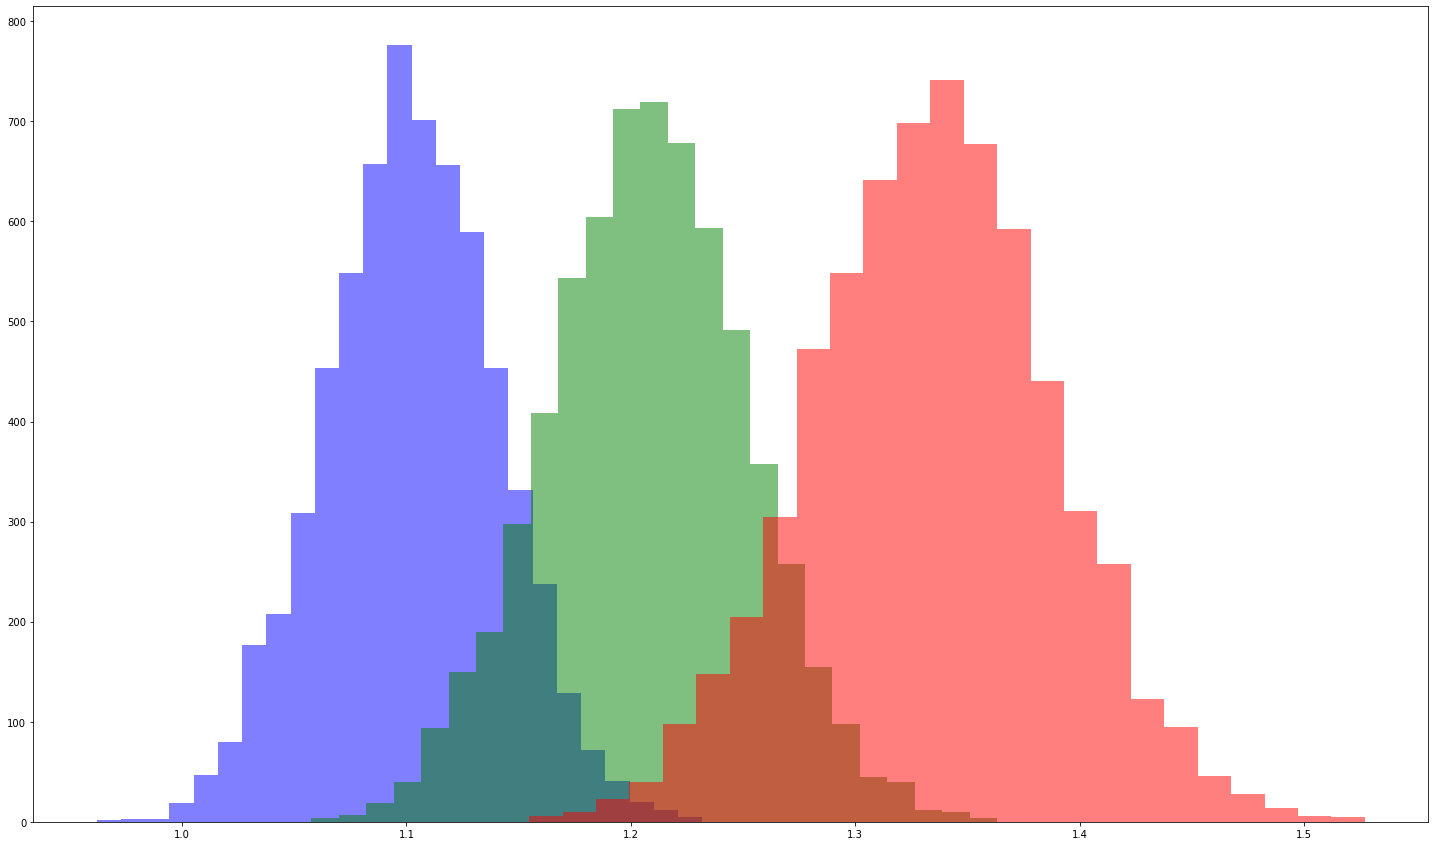

In [201]:
plt.hist(accepted_dataset_plus_stacked[0,:],bins=25,color="blue", alpha=0.5)
plt.hist(accepted_dataset_plus_stacked[1,:],bins=25,color="green", alpha=0.5)
plt.hist(accepted_dataset_plus_stacked[2,:],bins=25,color="red", alpha=0.5)
plt.show()

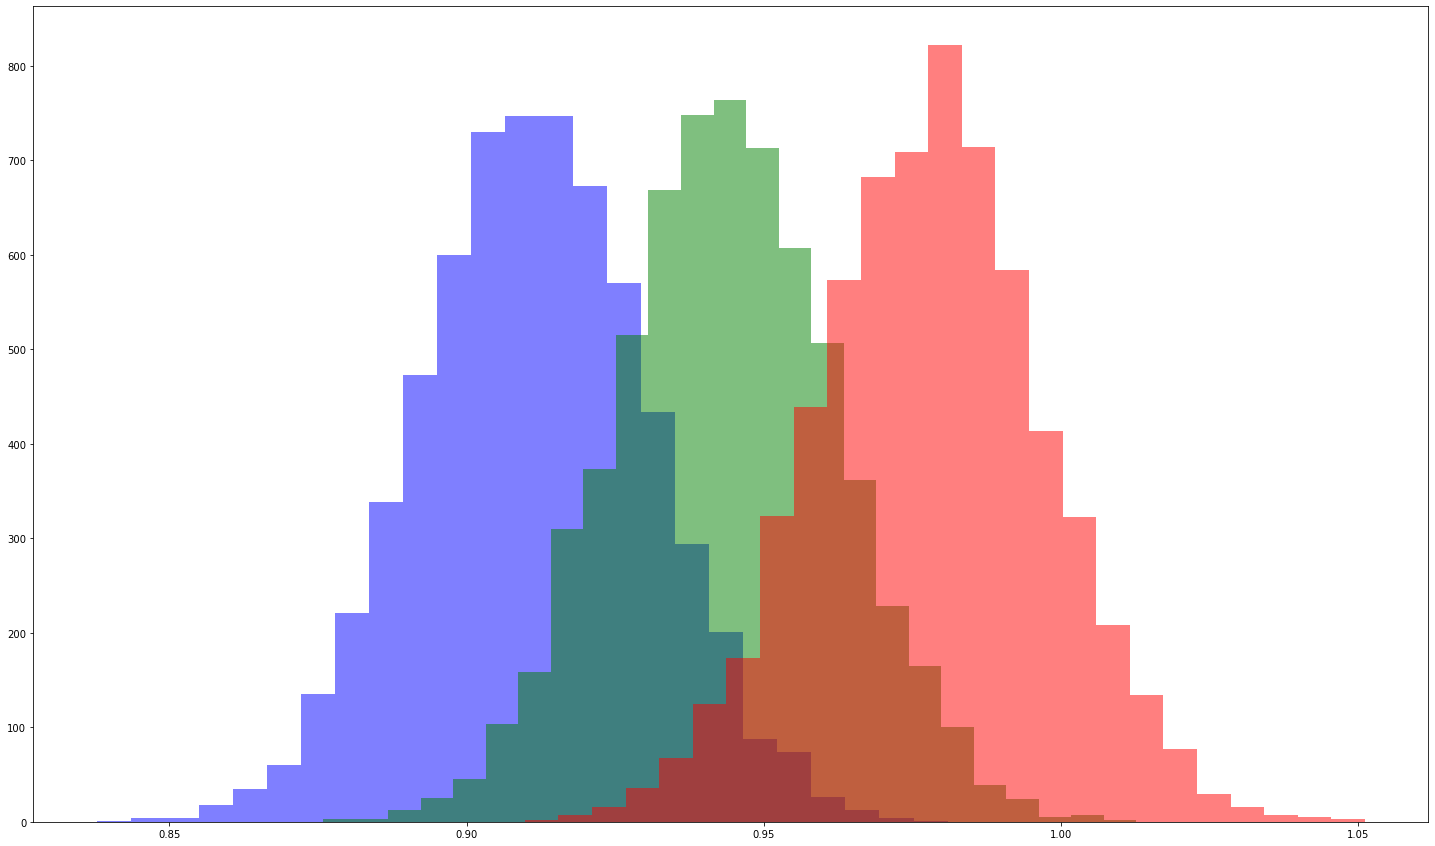

In [202]:
plt.hist(accepted_dataset_zero_stacked[0,:],bins=25,color="blue", alpha=0.5)
plt.hist(accepted_dataset_zero_stacked[1,:],bins=25,color="green", alpha=0.5)
plt.hist(accepted_dataset_zero_stacked[2,:],bins=25,color="red", alpha=0.5)
plt.show()

In [203]:
accepted_dataset_var[:,0] = data[:,0]
#for i in range(3):
accepted_dataset_var[:,1] = np.mean(accepted_dataset_plus_stacked,axis=1)
accepted_dataset_var[:,2] = np.std(accepted_dataset_plus_stacked,axis=1)
accepted_dataset_var[:,3] = np.mean(accepted_dataset_zero_stacked,axis=1)
accepted_dataset_var[:,4] = np.std(accepted_dataset_zero_stacked,axis=1)
for i in range(accepted_dataset_var.shape[0]):
    for j in range(accepted_dataset_var.shape[1]):
        accepted_dataset_var[i,j] = round(accepted_dataset_var[i,j],4)
accepted_dataset_var

array([[1.3461, 1.1023, 0.0382, 0.9113, 0.0192],
       [1.6154, 1.2074, 0.0446, 0.9437, 0.0187],
       [1.8846, 1.3343, 0.0539, 0.978 , 0.0192]])

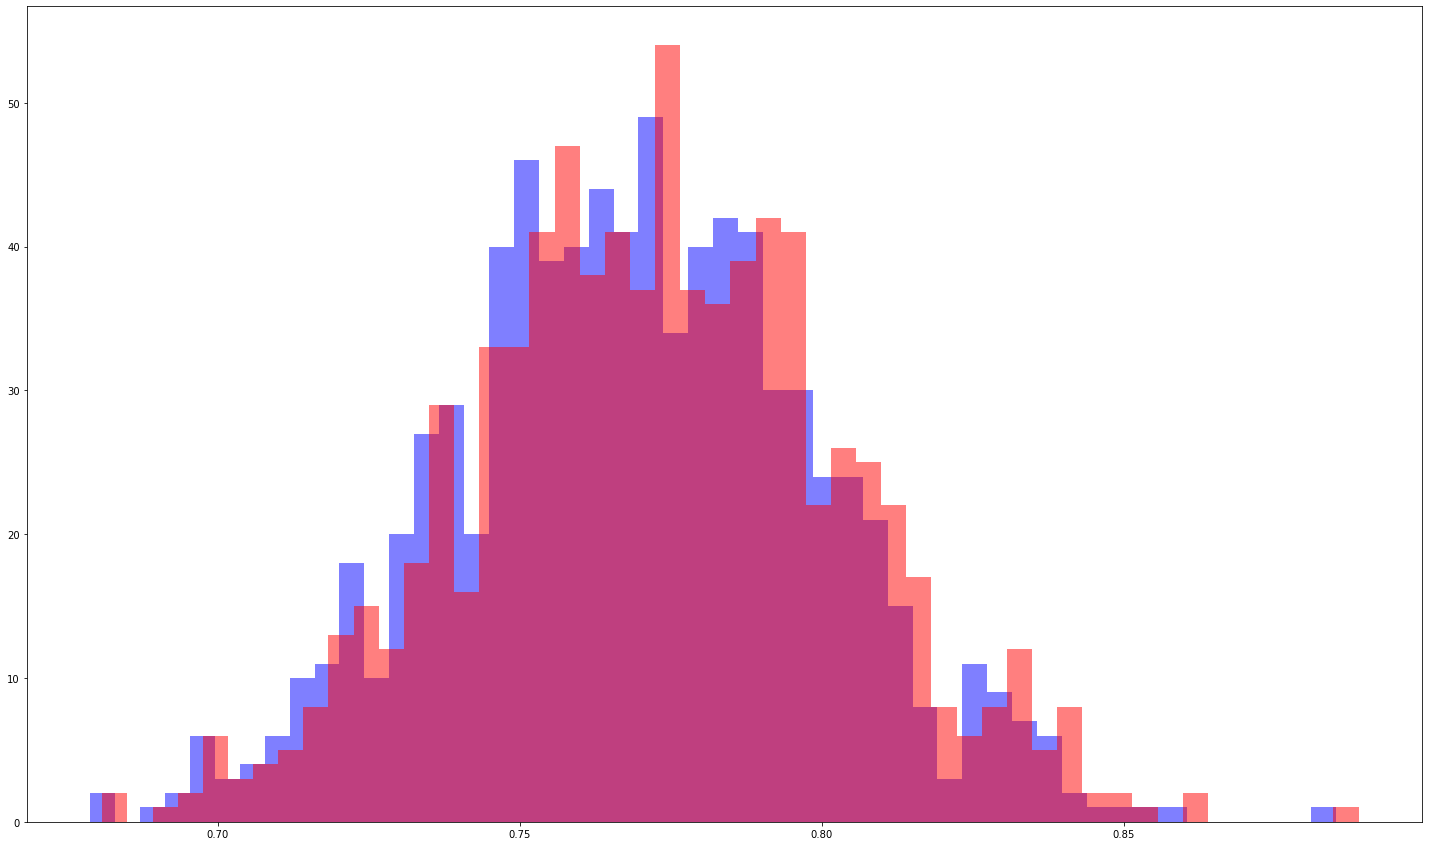

In [205]:
plt.hist(histzero[0,1],bins=50,color="blue", alpha=0.5)
plt.hist(histzero[0,2],bins=50,color="red", alpha=0.5)
plt.show()

In [193]:
len(histplus[0,2])

800

In [194]:
errortable = np.zeros([len(tchosenlist),5])
counter = 0
for t in tchosenlist:
    errortable[counter,0] = t
    errortable[counter,3] = round(dispresultszero[counter,1],3)
    errortable[counter,4] = round(dispresultszero[counter,1] - dispresultszero[counter,2],3)
    errortable[counter,1] = round(dispresultsplus[counter,1],3)
    errortable[counter,2] = round(dispresultsplus[counter,1] - dispresultsplus[counter,2],3)
    counter += 1

errortable

array([[0.    , 0.771 , 0.03  , 0.773 , 0.031 ],
       [0.2692, 0.819 , 0.031 , 0.797 , 0.027 ],
       [0.5385, 0.877 , 0.03  , 0.824 , 0.025 ],
       [0.8077, 0.938 , 0.031 , 0.852 , 0.022 ],
       [1.0769, 1.015 , 0.034 , 0.882 , 0.021 ],
       [1.3461, 1.102 , 0.037 , 0.911 , 0.02  ],
       [1.6154, 1.21  , 0.044 , 0.943 , 0.019 ],
       [1.8846, 1.334 , 0.055 , 0.977 , 0.019 ]])

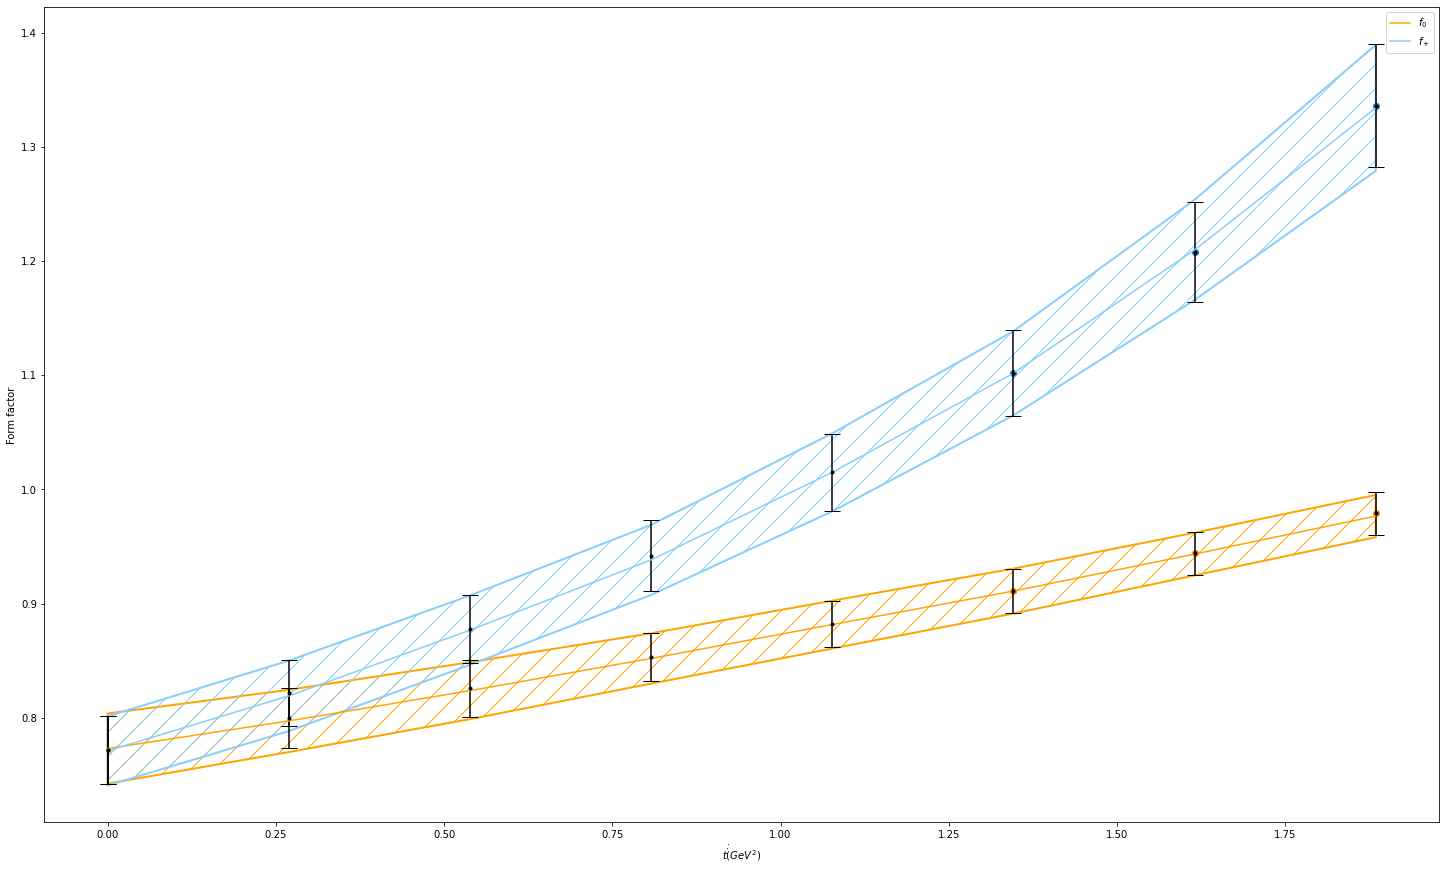

In [195]:
#x = np.linspace(0,2,101)
plt.scatter(data[:,0],data[:,1])
plt.scatter(data[:,0],data[:,2])
plt.plot(dispresultszero[:,0],dispresultszero[:,1],label = r"$f_0$",color="orange")
pl.fill_between(dispresultszero[:,0],dispresultszero[:,2],dispresultszero[:,3],linewidth=2,hatch='/',edgecolor="orange",facecolor="none")
plt.plot(dispresultsplus[:,0],dispresultsplus[:,1],label = r"$f_+$",color="lightskyblue")
pl.fill_between(dispresultsplus[:,0],dispresultsplus[:,2],dispresultsplus[:,3],linewidth=2,hatch='/',edgecolor="lightskyblue",facecolor="none")
romevals = np.array([[0.0, 0.765, 0.765, 0.772, 0.772],
[0.2692, 0.815, 0.792, 0.822, 0.800],
[0.5385, 0.872, 0.820, 0.878, 0.826],
[0.8077, 0.937, 0.849, 0.942, 0.853],
[1.0769, 1.013, 0.879, 1.015, 0.882],
[1.3461, 1.102, 0.911, 1.102, 0.911],
[1.6154, 1.208, 0.944, 1.208, 0.944],
[1.8846, 1.336, 0.979, 1.336, 0.979]])
romeerrorvals = np.array([
[0.031, 0.031, 0.030, 0.030],
[0.031, 0.028, 0.029, 0.026],
[0.031, 0.025, 0.030, 0.025],
[0.032, 0.023, 0.031, 0.021],
[0.034, 0.021, 0.034, 0.020],
[0.038, 0.019, 0.038, 0.019],
[0.044, 0.019, 0.044, 0.019],
[0.054, 0.019, 0.054, 0.019]])

#plt.scatter(romevals[:,0],romevals[:,3])
pl.errorbar(romevals[:,0], romevals[:,3], romeerrorvals[:,2], fmt='.k',capsize=8)
#plt.scatter(romevals[:,0],romevals[:,4])
pl.errorbar(romevals[:,0], romevals[:,4], romeerrorvals[:,3], fmt='.k',capsize=8)

#plt.xlim(0,1.1)
#plt.ylim(0.75,1.1)
plt.xlabel(r"$t \.\. (GeV^2)$")
plt.ylabel("Form factor")
plt.legend()
plt.rcParams["figure.figsize"] = (25,15)
plt.show()

In [ ]:
#x = np.linspace(0,2,101)
#plt.scatter(data[:,0],data[:,1])
#plt.scatter(data[:,0],data[:,2])
#plt.plot(dispresultszero[:,0],dispresultszero[:,1],label = r"$f_0$")
#plt.plot(dispresultszero[:,0],dispresultszero[:,2],label = r"$f_0$ Lower bound")
#plt.plot(dispresultszero[:,0],dispresultszero[:,3],label = r"$f_0$ Upper bound")
plt.plot(plusnonan[:,0],plusnonan[:,1],label = r"$f_+$")
plt.plot(plusnonan[:,0],plusnonan[:,2],label = r"$f_+$ Lower bound")
plt.plot(plusnonan[:,0],plusnonan[:,3],label = r"$f_+$ Upper bound")
romevals = np.array([[0.0, 0.765, 0.765, 0.772, 0.772],
[0.2692, 0.815, 0.792, 0.822, 0.800],
[0.5385, 0.872, 0.820, 0.878, 0.826],
[0.8077, 0.937, 0.849, 0.942, 0.853],
[1.0769, 1.013, 0.879, 1.015, 0.882]])
plt.scatter(romevals[:,0],romevals[:,3])
plt.scatter(romevals[:,0],romevals[:,4])
#plt.xlim(0,1.1)
#plt.ylim(0.75,1.1)
plt.xlabel(r"$t \.\. (GeV^2)$")
plt.ylabel("Form factor")
plt.legend()
plt.rcParams["figure.figsize"] = (15,15)
plt.show()

In [214]:
def zerohistogramdata(chg,Nboot):
    upperlist = []
    lowerlist = []
    unifailcount = 0
    for y in tqdm(range(Nboot)):
        newdata = covresample(data)
        chiplus = np.random.normal(chi1minus,0.00036)
        chizero = np.random.normal(chi0plus,0.00133)
        
        if chg == 1:
            chi = chiplus
        if chg == 0:
            chi = chizero
        
        bounds = formfactor(newdata,0,chg,chi)
        upper = bounds[1]
        lower = bounds[0]
        if upper <= lower:
            continue
        if np.linalg.det(M11(newdata,tchosen,1,chiplus)) < 0 or np.linalg.det(M11(newdata,tchosen,0,chizero)) < 0:
            #print("unitarity check failed")
            unifailcount += 1
            continue
        
        upperlist.append(upper)
        lowerlist.append(lower)
    print("for t = 0 unitarity fail percentage is ",(unifailcount*100)/Nboot,"%")
    print("for t = 0 other fail percentage is ",((Nboot-len(lowerlist)-unifailcount)*100)/Nboot,"%")
    return [lowerlist,upperlist]

In [230]:
histresults = zerohistogramdata(1,50000)

100%|██████████| 50000/50000 [07:23<00:00, 112.73it/s]

for t = 0 unitarity fail percentage is  17.844 %
for t = 0 other fail percentage is  0.0 %


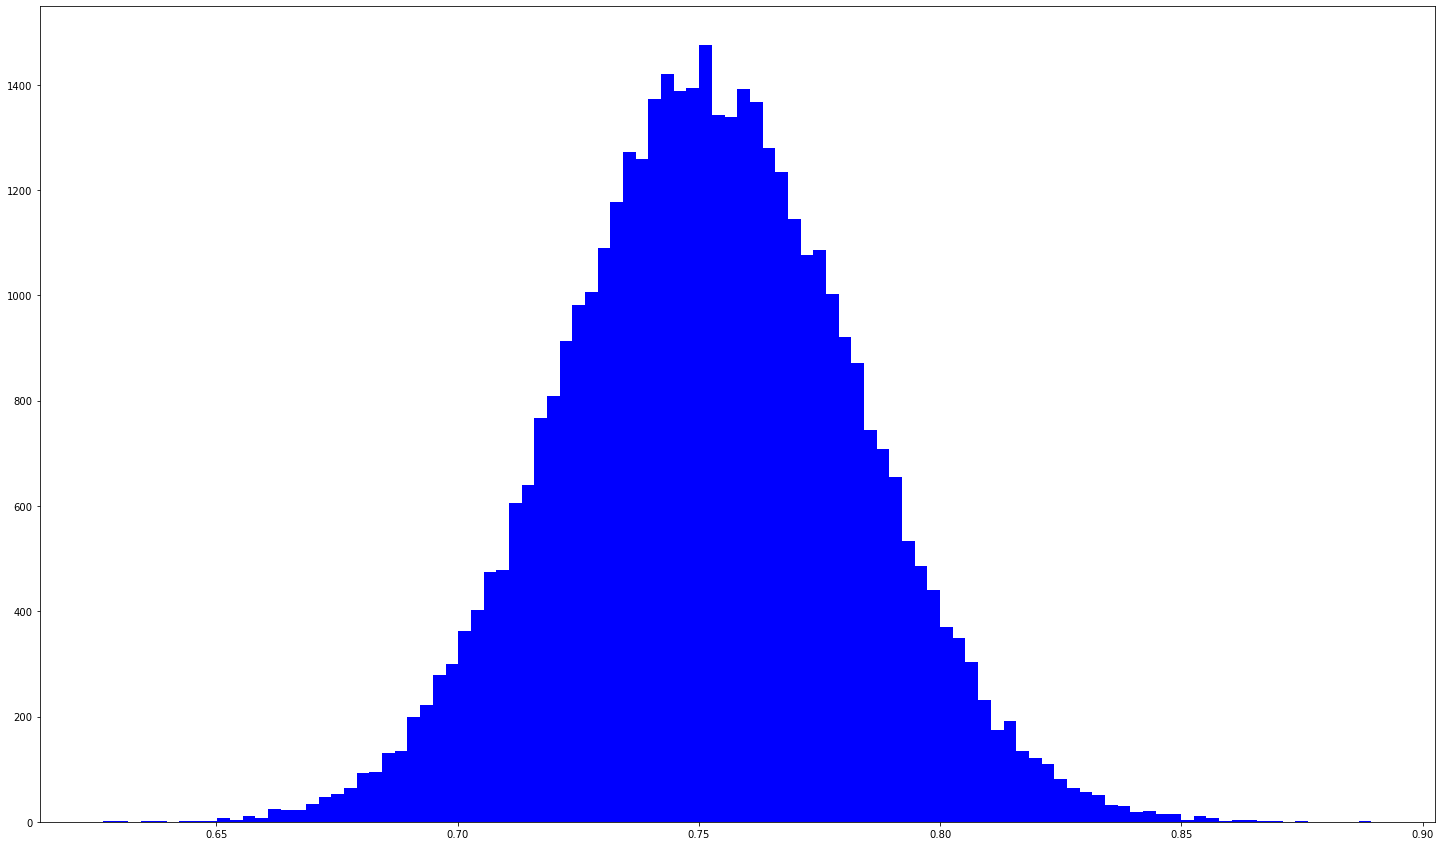

In [231]:
plt.hist(histresults[0],bins=100,color="blue", alpha=1)
plt.show()

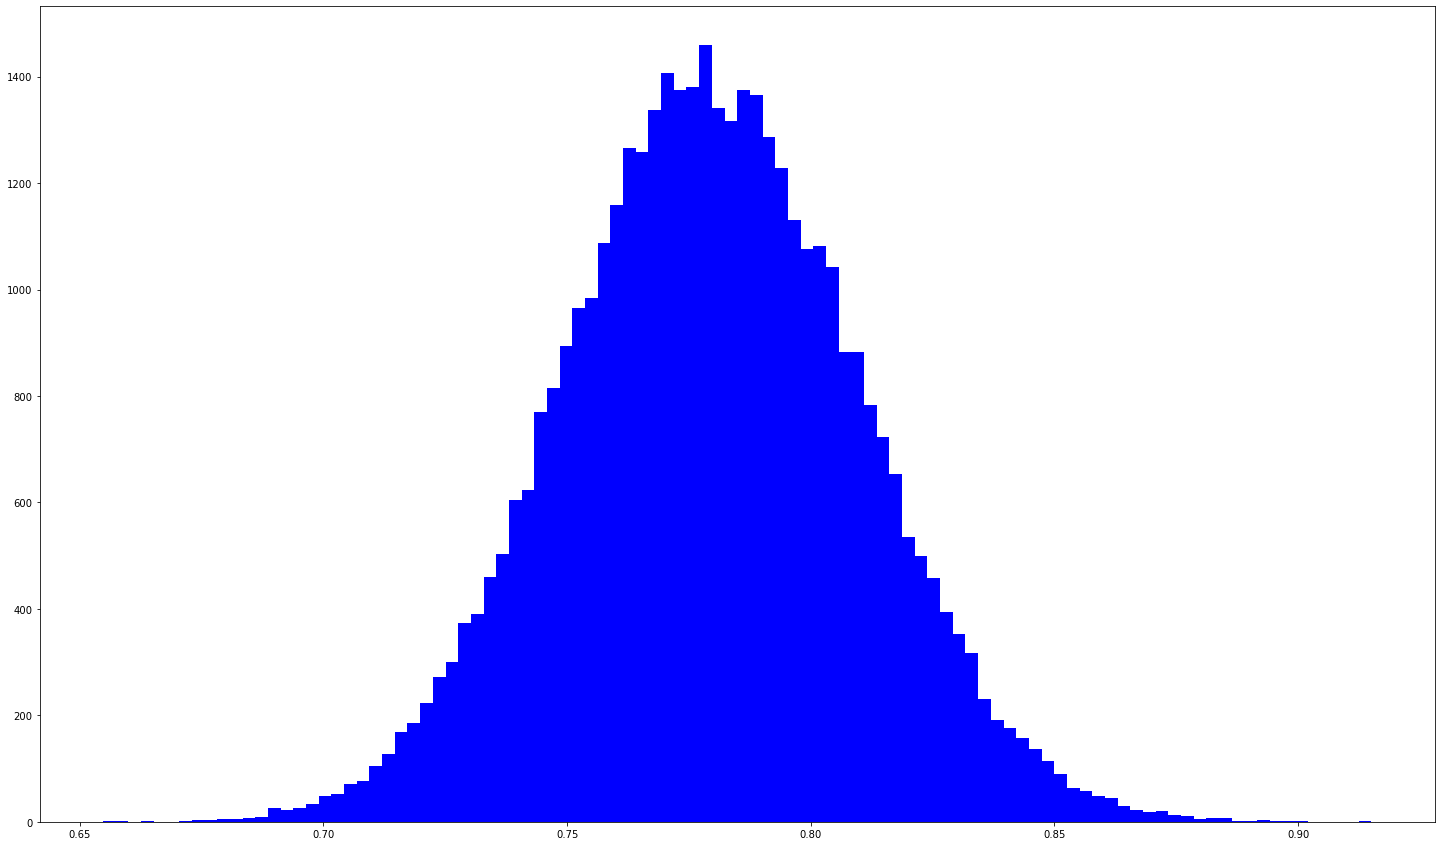

In [232]:
plt.hist(histresults[1],bins=100,color="blue", alpha=1)
plt.show()

In [234]:
histresultstable = np.zeros([1,4])
histresultstable[0,0] = np.mean(histresults[0])
histresultstable[0,1] = np.std(histresults[0])
histresultstable[0,2] = np.mean(histresults[1])
histresultstable[0,3] = np.std(histresults[1])
for i in range(histresultstable.shape[0]):
    for j in range(histresultstable.shape[1]):
        histresultstable[i,j] = round(histresultstable[i,j],4)
histresultstable

array([[0.7521, 0.0304, 0.7794, 0.0304]])